In [1]:
!mamba install t-coffee mmseqs2 -y -q

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from learnMSA.msa_hmm import Configuration, Align, Visualize
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset

2024-06-18 14:59:57.289394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 14:59:59.049863: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 15:00:01.730382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/beckerf/mambaforge/envs/learnMSAdev/lib/:/home/beckerf/.local/lib/python3.10/site-packages/nvidia/cudnn/lib:
2024-06-18 15:00:01.732216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could

## learnMSA demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 4

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

## Run learnMSA from Python (Training + Viterbi alignment)

Training of 4 models on file egf.fasta
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=10000

2024-06-18 15:00:25.428344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:25.428551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:25.428703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:25.428883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:25.429027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Epoch 1/10


2024-06-18 15:00:28.085771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:28.086065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:28.086274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:28.086524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:28.086724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

17/17 - 17s - loss: 115.1505 - loglik: -9.2848e+01 - logprior: -2.2303e+01 - 17s/epoch - 1s/step
Epoch 2/10
17/17 - 1s - loss: 80.2014 - loglik: -7.5397e+01 - logprior: -4.8048e+00 - 1s/epoch - 63ms/step
Epoch 3/10
17/17 - 1s - loss: 71.7654 - loglik: -6.8967e+01 - logprior: -2.7981e+00 - 1s/epoch - 64ms/step
Epoch 4/10
17/17 - 1s - loss: 69.4918 - loglik: -6.7202e+01 - logprior: -2.2895e+00 - 1s/epoch - 67ms/step
Epoch 5/10
17/17 - 1s - loss: 68.8616 - loglik: -6.6799e+01 - logprior: -2.0629e+00 - 1s/epoch - 70ms/step
Epoch 6/10
17/17 - 1s - loss: 68.9017 - loglik: -6.6994e+01 - logprior: -1.9079e+00 - 1s/epoch - 66ms/step


2024-06-18 15:00:52.439676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:52.439920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:52.440102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:52.440320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:52.440506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

expansions model 0: [(12, 2), (13, 2), (14, 1), (16, 1)]
discards model 0: []
expansions model 1: [(12, 7), (15, 1), (17, 2)]
discards model 1: []
expansions model 2: [(12, 2), (13, 3), (14, 1), (17, 1), (19, 2)]
discards model 2: []
expansions model 3: [(10, 1), (11, 2), (12, 3), (13, 1), (16, 1), (18, 2)]
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [33, 33, 34, 34] on 7774 sequences.
Batch size= 512 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


2024-06-18 15:00:55.894396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:55.894668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:55.894859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:55.895086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:55.895274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Epoch 1/2


2024-06-18 15:00:57.307395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:57.307673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:57.307863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:57.308088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:00:57.308275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

17/17 - 11s - loss: 84.1235 - loglik: -6.4312e+01 - logprior: -1.9811e+01 - 11s/epoch - 664ms/step
Epoch 2/2
17/17 - 1s - loss: 67.3517 - loglik: -6.3082e+01 - logprior: -4.2696e+00 - 1s/epoch - 69ms/step


2024-06-18 15:01:10.985041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:10.985323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:10.985514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:10.985738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:10.985926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

expansions model 0: []
discards model 0: [13 18]
expansions model 1: []
discards model 1: [25]
expansions model 2: []
discards model 2: [12 26]
expansions model 3: []
discards model 3: [12 19 26]
Re-initialized the encoder parameters.
Fitting models of lengths [31, 32, 32, 31] on 7774 sequences.
Batch size= 512 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


2024-06-18 15:01:14.027218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:14.027423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:14.027561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:14.027733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:14.027874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Epoch 1/2


2024-06-18 15:01:15.484042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:15.484265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:15.484413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:15.484591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:15.484733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

17/17 - 12s - loss: 81.7562 - loglik: -6.1944e+01 - logprior: -1.9812e+01 - 12s/epoch - 688ms/step
Epoch 2/2
17/17 - 1s - loss: 66.6081 - loglik: -6.2556e+01 - logprior: -4.0517e+00 - 1s/epoch - 67ms/step


2024-06-18 15:01:29.524828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:29.525101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:29.525289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:29.525507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:29.525690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

expansions model 0: []
discards model 0: []
expansions model 1: []
discards model 1: [15]
expansions model 2: []
discards model 2: []
expansions model 3: []
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 32, 31] on 7774 sequences.
Batch size= 512 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


2024-06-18 15:01:32.678229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:32.678647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:32.678954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:32.679331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:32.679645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Epoch 1/10


2024-06-18 15:01:34.108803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:34.109078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:34.109269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:34.109494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:34.109683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

17/17 - 12s - loss: 82.9956 - loglik: -6.1703e+01 - logprior: -2.1293e+01 - 12s/epoch - 684ms/step
Epoch 2/10
17/17 - 1s - loss: 66.8926 - loglik: -6.2508e+01 - logprior: -4.3846e+00 - 1s/epoch - 65ms/step
Epoch 3/10
17/17 - 1s - loss: 64.9020 - loglik: -6.2739e+01 - logprior: -2.1633e+00 - 1s/epoch - 64ms/step
Epoch 4/10
17/17 - 1s - loss: 64.5775 - loglik: -6.3121e+01 - logprior: -1.4565e+00 - 1s/epoch - 67ms/step
Epoch 5/10
17/17 - 1s - loss: 64.1725 - loglik: -6.3061e+01 - logprior: -1.1110e+00 - 1s/epoch - 64ms/step
Epoch 6/10
17/17 - 1s - loss: 64.2994 - loglik: -6.3387e+01 - logprior: -9.1280e-01 - 1s/epoch - 63ms/step
Time for alignment: 88.9724


2024-06-18 15:01:51.235416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:51.235636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:51.235794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:51.235980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:51.236130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Likelihoods:  ['-59.0695', '-59.0858', '-59.0943', '-59.1192']
Mean likelihood:  -59.092197945224065
Selection criterion: AIC
Best model:  0 (0-based)


2024-06-18 15:01:56.745700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:56.745943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:56.746121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:56.746333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:56.746524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Aligning 2 insertion slices with famsa.
time for generating output: 2.3631
Wrote file test/data/interactive.alignment.fasta


2024-06-18 15:01:59.235490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:59.235758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:59.235949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:59.236168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:01:59.236348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

16/16 [==============================] - 3s 42ms/step
>l=-54.81_t=0.01
............$C....D.......P......N............P........CYN.HG..T..C...S.......L......RA...T......................G.....YTCSCL....PR......YT....GEH$.......................
>l=-57.33_t=0.01
............$C....D.......S......Q............P........CRN.-G..T..C...Sl......N......TN...T......................D.....YTCACF....PG......YT....GRY$.......................
>l=-49.89_t=0.01
............$C....D.......S......D............P........CLN.GG..T..C...T.......L......RSl..D......................S.....YSCACA....PG......YT....GQH$.......................
>l=-63.74_t=0.01
............$C....D.......H......V............T........CLN.GG..T..C...Q.......Lk.....TL...E......................D.....YTCACA....NG......YT....GER$.......................
>l=-64.14_t=0.01
............$C....D.......H......V............T........CLN.GG..T..C...Q.......Lk.....TL...E......................E.....YTCACA....NG......YT....GDR$.......................
>l=-64

2024-06-18 15:02:01.937144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:02:01.937422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:02:01.937644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:02:01.937895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-18 15:02:01.938116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

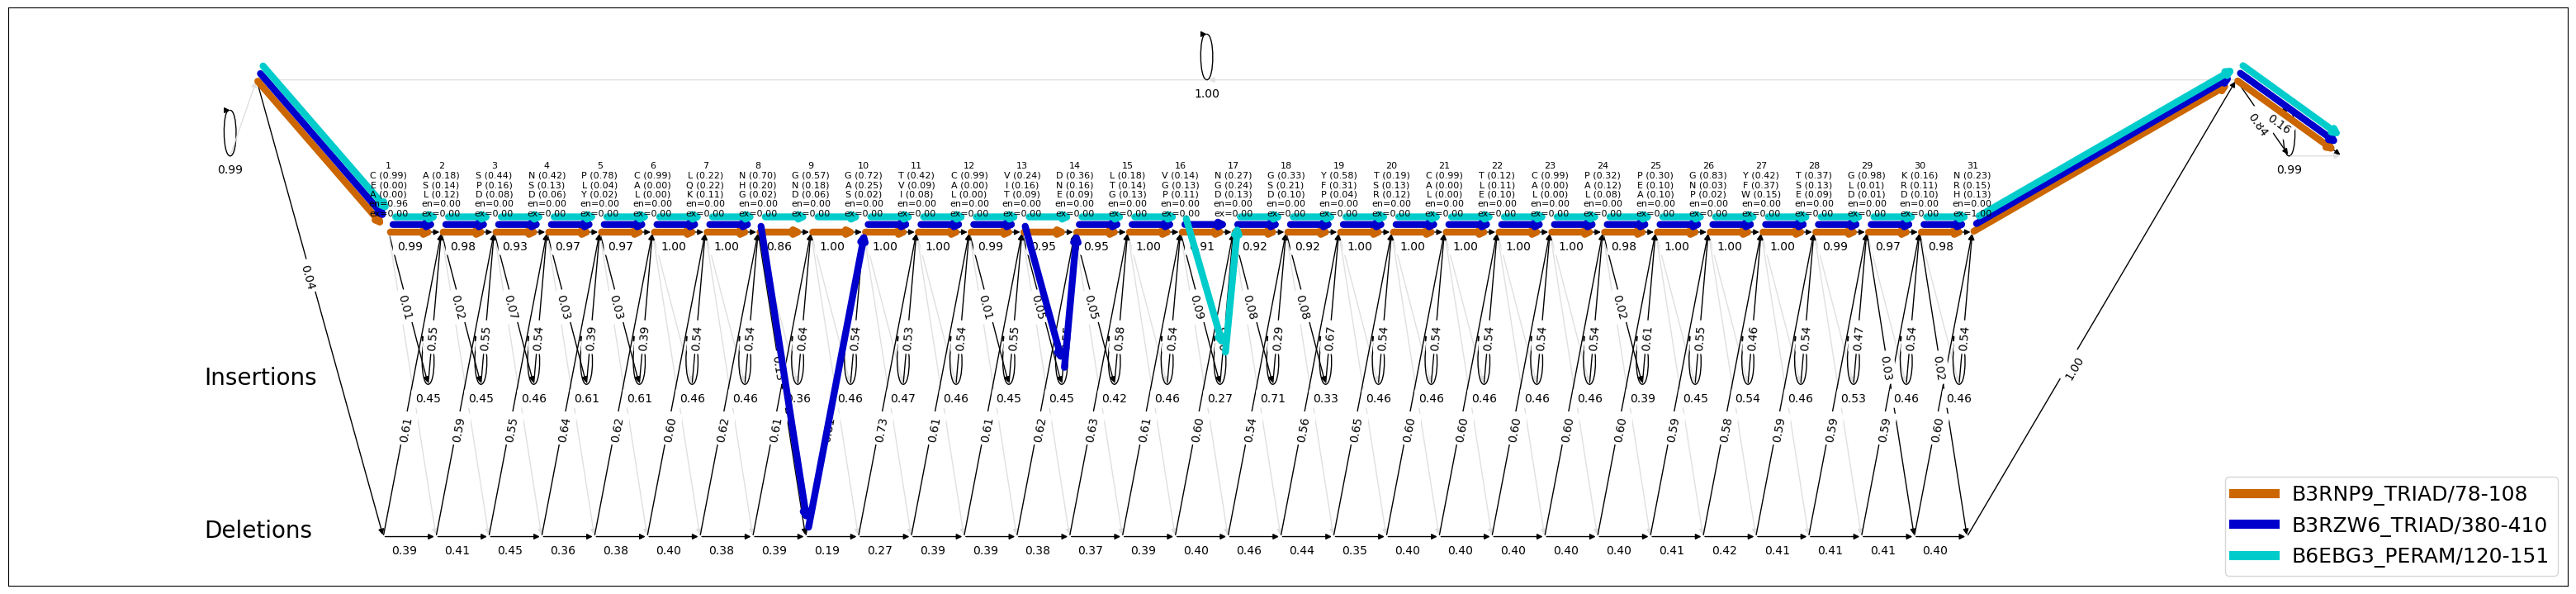

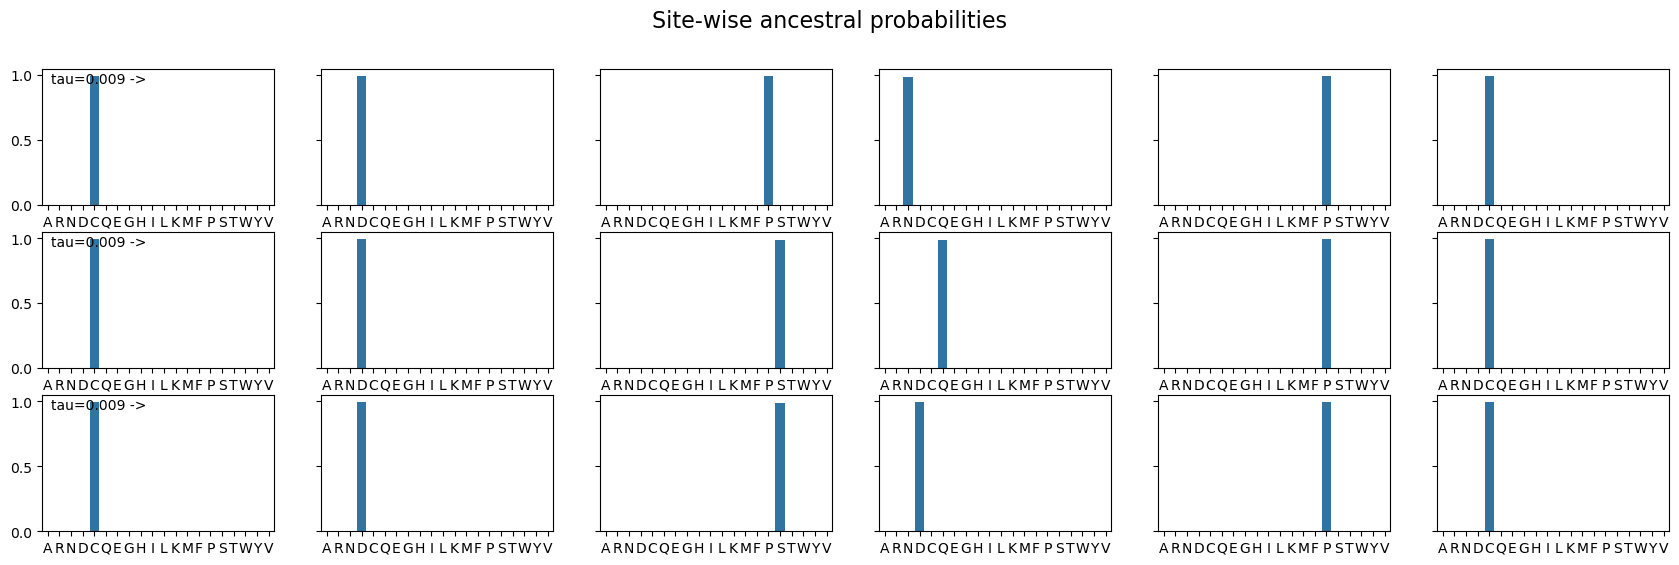

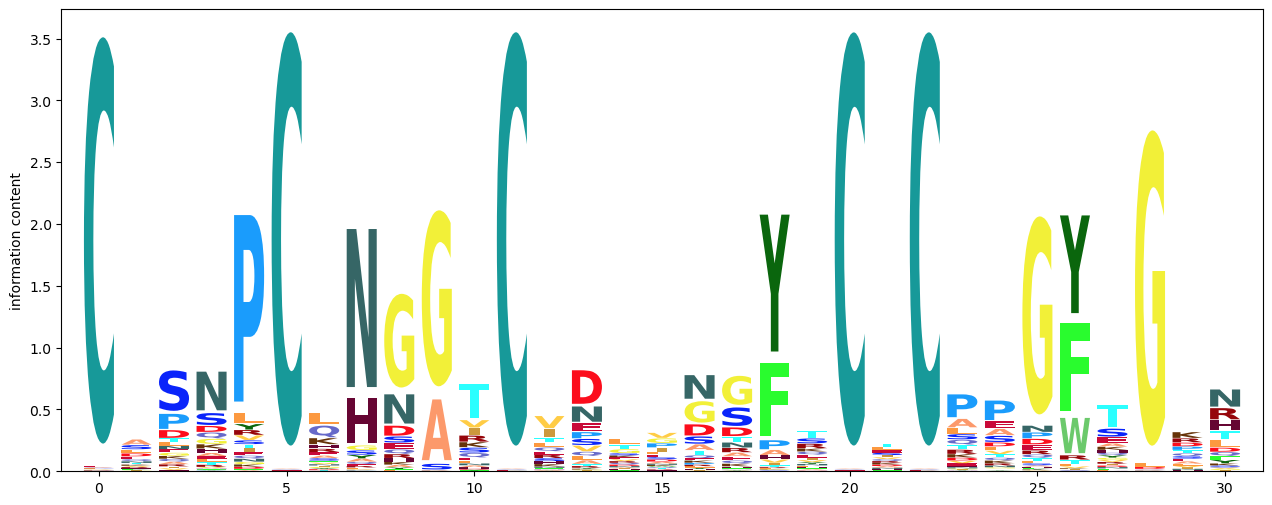

In [3]:
out_filename = "test/data/interactive.alignment.fasta"
config = Configuration.make_default(num_models)
with SequenceDataset(train_filename, fmt="fasta") as data:
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        sequence_weights=Align.compute_sequence_weights(train_filename, "tmp") if use_weights else None,
                                        verbose=True,
                                        align_insertions=align_insertions)
    Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [19]:
import numpy as np

anc_probs_file = "test.anc_probs.out"
i = [l.name for l in alignment_model.encoder_model.layers].index("anc_probs_layer")
anc_probs_layer = alignment_model.encoder_model.layers[i]
indices = np.stack([alignment_model.indices]*alignment_model.msa_hmm_layer.cell.num_models)
indices = np.expand_dims(indices, -1)
tau = anc_probs_layer.make_tau(indices)[alignment_model.best_model]
with open(anc_probs_file, "w") as file:
    for i,t in zip(alignment_model.data.seq_ids, tau):
        file.write(f"{i}\t{t.numpy()}\n")

In [24]:
np.sort(tau)[-200:]

array([0.19737208, 0.19803837, 0.19859594, 0.19945765, 0.19983898,
       0.20023198, 0.2003148 , 0.20085901, 0.20148589, 0.2018882 ,
       0.20194441, 0.20204829, 0.20214537, 0.20217459, 0.202821  ,
       0.20365305, 0.20416242, 0.20450895, 0.20454781, 0.20535094,
       0.20571876, 0.20581791, 0.20596097, 0.2062399 , 0.20706807,
       0.20797813, 0.20812982, 0.20865864, 0.208732  , 0.20915978,
       0.21072711, 0.21249194, 0.21402405, 0.2141578 , 0.21438713,
       0.2145628 , 0.21457951, 0.21471289, 0.21511166, 0.2157814 ,
       0.21579513, 0.2160236 , 0.2161861 , 0.21700607, 0.21741898,
       0.2174794 , 0.21752799, 0.21774244, 0.21824642, 0.21857953,
       0.21870302, 0.22150776, 0.22242776, 0.22247326, 0.22255567,
       0.22371398, 0.22390713, 0.22405082, 0.22556342, 0.2264768 ,
       0.22707061, 0.22726166, 0.22773865, 0.2283833 , 0.22841372,
       0.22994773, 0.2302796 , 0.23104435, 0.23227902, 0.23420842,
       0.23484755, 0.23507226, 0.2353255 , 0.23533201, 0.23659

['B3RNP9_TRIAD/78-108',
 'B3RZW6_TRIAD/380-410',
 'B6EBG3_PERAM/120-151',
 'B4Q0L7_DROYA/117-148',
 'B3NTZ8_DROER/120-151',
 'NOTCH_DROME/143-174',
 'B4IA25_DROSE/120-151',
 'B5DM97_DROPS/135-166',
 'B4GYL6_DROPE/117-148',
 'B3N1W3_DROAN/140-173',
 'B4L8A9_DROMO/212-243',
 'B4MCT2_DROVI/116-147',
 'B4JJG8_DROGR/143-174',
 'B4NQ59_DROWI/118-149',
 'Q7Z1J1_DROME/56-90',
 'Q7Z1J0_DROSI/56-90',
 'Q7YSR5_DROME/56-90',
 'Q7KPY6_LUCCU/87-118',
 'Q25253_LUCCU/125-156',
 'Q16TK9_AEDAE/139-170',
 'A0NBR1_ANOGA/72-103',
 'B0WGH6_CULQU/65-96',
 'Q68QF3_LITFO/113-144',
 'Q8I6X6_BOOMI/118-149',
 'A0MK40_9CRUS/106-137',
 'Q8I499_CUPSA/46-77',
 'Q869J7_9MYRI/118-149',
 'B3RNP6_TRIAD/203-238',
 'C3ZBX6_BRAFL/360-385',
 'A7RST6_NEMVE/28-61',
 'B3RX46_TRIAD/1-28',
 'B3SCF4_TRIAD/1-31',
 'B3SC77_TRIAD/211-241',
 'B3RRK2_TRIAD/2-32',
 'B4Y0U8_9METZ/219-251',
 'A7T290_NEMVE/14-46',
 'A7T268_NEMVE/161-193',
 'A7RR01_NEMVE/252-284',
 'A7T268_NEMVE/38-70',
 'A7RR01_NEMVE/46-78',
 'A7T268_NEMVE/79-111',
 'A7RSU

In [13]:
alignment_model.best_model

0

In [ ]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in rhv.out -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

In [ ]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp